# Part 04 DATA PREP

# 0.0. Imports

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Scalers
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# Feature selection
from boruta import BorutaPy

# Machine Learning models
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# 5.0. Data Preparation 

In [2]:
# Load dataset
feature_dtypes = {'step': 'int16',
                  'type': 'category',
                  'amount': 'float32',
                  'name_orig': 'object',
                  'oldbalance_orig': 'float32',
                  'newbalance_orig': 'float32',
                  'name_dest': 'object',
                  'oldbalance_dest': 'float32',
                  'newbalance_dest': 'float32',
                  'is_fraud': 'uint8',
                  'is_flagged_fraud': 'uint8',
                  'error_orig' : 'float32',
                  'error_dest' : 'float32',
                  'dest_type' : 'category',
                  'days' : 'int8'}

df2 = pd.read_csv('dataset\df2.csv', dtype=feature_dtypes)

## 5.1. Transformation

In [3]:
df3 = df2.copy()

In [4]:
types_col = {
    'CASH_IN' : 0,
    'CASH_OUT' : 1, 
    'DEBIT': 2,
    'PAYMENT': 3,
    'TRANSFER': 4}
dest_type = {
    'C': 0,
    'M': 1}

df3.type = df3.type.map(types_col)
df3.dest_type = df3.dest_type.map(dest_type)

## 5.2. Rescaling

In [5]:
# Min - Max Scaler
mms = MinMaxScaler()
df3.step = mms.fit_transform(df3[['step']].values)
df3.days = mms.fit_transform(df3[['days']].values)

In [6]:
# Robust Scaler
rs = RobustScaler()
cols_for_robust = ['amount', 'oldbalance_orig', 'newbalance_orig', 'oldbalance_dest', 'newbalance_dest' ]

for i in cols_for_robust:
    df3[i] = rs.fit_transform(df3[[i]].values) 

## 5.3. Standardization

None of the numerical variables have a normal distribution.

# 6.0. Feature Selection

## 6.1. Drop and Split Columns

In [7]:
# Removing unnecessary columns
df3 = df3.drop(['name_orig', 'name_dest'], axis = 1)

# Variables
X_feature = df3.drop('is_fraud', axis=1)

# Target variable
Y_feature = df3.is_fraud

## 6.2. Feature Importance

[0.02440702 0.02840301 0.08756767 0.05702182 0.36723484 0.02453286
 0.07278183 0.00060539 0.22264835 0.09397743 0.00223826 0.01858151]


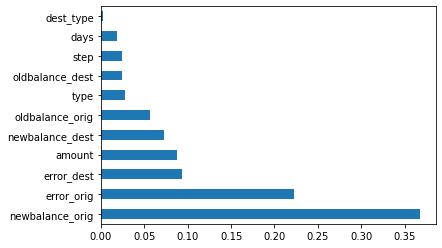

In [8]:
# Selecting Model
model = RandomForestClassifier()
model.fit(X_feature, Y_feature)

# Use inbuilt class feature_importances of tree based classifiers
print(model.feature_importances_)
 
# Plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_feature.columns)
feat_importances.nlargest(11).plot(kind='barh')
plt.show()

## 6.3. Boruta

In [9]:
# Train using random forest classifier

# X train
X_boruta = X_feature.values

# Y train
Y_boruta = Y_feature.values

# Define random forest classifier
rf = RandomForestClassifier(n_estimators=200, n_jobs=4, max_depth = 6, class_weight='balanced')

# Define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_boruta, Y_boruta)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	12
Tentative: 	0
Rejected: 	0


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	12
Tentative: 	0
Rejected: 	0


### 6.3.1. Best features

In [10]:
# Check selected features
cols_selected_boruta = feat_selector.support_.tolist()
columns_selected = df3.drop(['is_fraud'], axis=1).loc[:, cols_selected_boruta].columns.tolist()
columns_selected

['step',
 'type',
 'amount',
 'oldbalance_orig',
 'newbalance_orig',
 'oldbalance_dest',
 'newbalance_dest',
 'is_flagged_fraud',
 'error_orig',
 'error_dest',
 'dest_type',
 'days']

In [11]:
# Saving datase
df3.to_csv('dataset\df3.csv', index=False)